In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import os

from astropy.io import fits
from skimage.filters import threshold_otsu

from scipy.ndimage import shift
from scipy.optimize import curve_fit

from sfilter import sfilter

np.seterr(all="ignore")

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [16]:
def gamma_poly(Vx, Vy, Cn2, z):
    global D, Dpix, latency, sec_per_frame
    nx = 2 * Dpix + 2 # размер окна автокорреляции зрачка, должно быть в 2 раза больше чем размер зрачка
    const = 9.69*pow(10, -3)*16*pow(np.pi, 2) # константа перед интегралом 
        
    f_scale = Dpix/(D*nx) # шаг по частоте, [м^-1]
    delta = D/Dpix # шаг апертуры (соотношение между 1 пикселем и метрами, т.е. 1 пикс = 0.01 м) 

    xx, yy = np.meshgrid(np.linspace(-nx//2, nx//2-1, nx), np.linspace(-nx//2, nx//2-1, nx))
    fx = f_scale * xx 
    fy = f_scale * yy
    
#     t = sec_per_frame * latency
#     Lx = Vx*t
#     Ly = Vy*t
#     Xpix = Lx/delta
#     Ypix = Ly/delta
    
    def gamma_poly_int(fx, fy, xx, yy, z, delta): 
        def aperture_func(fx, fy, delta): 
            res = np.abs(np.sinc(delta*fx)*np.sinc(delta*fy))**2
            return res
    
        def abs_f(fx, fy):
            res = pow(np.sqrt(fx**2+fy**2), -11./3.)
            res[np.isnan(res)] = 0
            return res
        
        S = sfilter(D=D, Dpix=Dpix, z=z)    
    
        res = abs_f(fx, fy) * S * aperture_func(fx, fy, delta)
        res[np.isnan(res)] = 0
    
        return np.fft.fftshift(np.real(np.fft.ifft2(np.fft.fftshift(res))))
    
    res = Cn2 * const * gamma_poly_int(fx, fy, xx, yy, z, delta) * pow(f_scale, 2) * nx * nx
#     res = shift(res, (-Xpix, -Ypix), order=5)
    res = shift(res, (Vy-228, Vx-228), order=5)


    return res

In [3]:
D = 2.5
Dpix = 228
data_corr_shape = 228
latency = 4
sec_per_frame = 0.01
z = 2000

xdata2 shape: (2, 458)


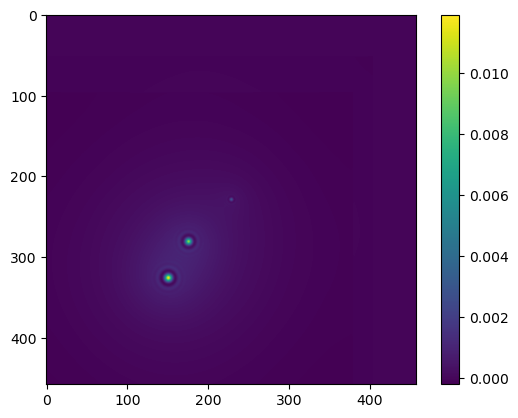

In [26]:
x = range(2*Dpix+2)
y = range(2*Dpix+2)
xdata2 = np.vstack((x, y))
print('xdata2 shape:', xdata2.shape)

Cn2 = 1*pow(10, -13)

layers = [[228, 228, Cn2, 2000], [175, 280, Cn2, 8000], [150, 325, Cn2, 10000]]
values = (gamma_poly(*layers[0]) + gamma_poly(*layers[1]) + gamma_poly(*layers[2])) 

plt.figure()
plt.imshow(values)
plt.colorbar()